In [22]:
import numpy as np
import matplotlib.pyplot as plt

from utils import smooth, system_matrix_1d
from fem_assembly import assembly_1d

In [23]:
def restrict(x, sparse=False):
    """Applies the restriction operator to vector x. 

    Parameters
    ----------
    x : numpy.array
        vector on finer grid

    Returns
    ------- 
    numpy.array
        vector on coarse grid
    """
    n = x.shape[0]
    nr = int((n-1)/2)
    R = np.zeros((nr, n))
    R[:,0] = 0.5
    R[:,1] = 1
    R[:,2] = 0.5

    # Roll rows of R
    r = np.arange(0, 2*R.shape[0], 2)
    rows, column_indices = np.ogrid[:R.shape[0], :R.shape[1]]
    r[r < 0] += R.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    R = R[rows, column_indices]
    x_restricted =  np.matmul(R, x)

    return x_restricted

In [24]:
def interpolate(x, sparse=False):
    """Applies the interpolation operator to vector x

    Parameters
    ----------
    x : numpy.array
        vector on coarse grid

    Returns
    ------- 
    numpy.array
        vector on fine grid
    """
    # Pad with zeros
    x_padded = np.concatenate(([0], x, [0]))
    ni = 2*x.shape[0]+1
    I = np.zeros((ni, x_padded.shape[0]))
    I[::2,0:2] = [0.5, 0.5]
    I[1::2,0] = 1

    # Roll rows of I
    r = np.zeros(I.shape[0]+1)
    r[::2] = np.arange((r.shape[0])/2)
    r[1::2] = np.arange(r.shape[0]/2)
    r = r[1:]

    for k in range(r.shape[0]):
        I[k,:] = np.roll(I[k,:], int(r[k]))

    return np.matmul(I, x_padded)

In [27]:
def P(i, f):
    """Generate the problem for 1-dimensional discrete Poisson equation

    Parameters
    ----------
    i : int
        Number of unknowns will be 2**i - 1
        
    f : function
        The load function

    Returns
    -------
    numpy.array
        System matrix  
    numpy.array
        right-hand side
    numpy.array
        grid
    """
    number_of_points = 2**i + 1
    t = np.linspace(0, 1, number_of_points)
    T = system_matrix_1d(i)
    b = f(t[1:-1])
    return T, b, t[1:-1]

In [26]:
def P_fem(i, f):
    """Generate the problem for 1-dimensional discrete Poisson equation with dirichlet 
    boundary conditions u(0)=u(1)=0, discretized
    by the finite element method.

    Parameters
    ----------
    i : int
        Number of unknowns will be 2**i - 1
        
    f : function
        The load function

    Returns
    -------
    numpy.array
        System matrix  
    numpy.array
        right-hand side
    numpy.array
        grid
    """
    # Define nodes and edges of the fem discretization
    N_n = 2**i + 1
    N_e = N_n - 1
    nodes = np.linspace(0, 1, N_n)
    elem = np.vstack((range(N_e), range(1, N_e+1))).T

    # Assemble the system and account for boundary conditions
    A, b = assembly_1d(f, nodes, elem)
    T = A[1:N_e, 1:N_e]
    b = b[1:N_e]

    return T, b, nodes[1:N_e]

In [31]:
# Multigrid V-cycle
def MGV(b, x, i, iter_smooth=1):
    """Recursive Multigrid V-cycle algorithm

    Parameters
    ----------
    b_i : numpy.array
        right-hand side of problem P(i), fine grid
        
    x_i : numpy.array
        approximate solution of problem P(i), fine grid

    Returns
    -------
    numpy.array
        solution to the problem P(i)
    """
    T, _, _ = P_fem(i, f)
    
    if i == 1:
        #print("MGV called with i = 1")
        x = np.linalg.solve(T, b)
        return x
    else:
        #print("MGV called with i = ", i)
        # Smoothen the approximate solution
        x = smooth(x=x, A=T, b=b, n_iter=iter_smooth)
        
        # Calculate residual
        r = np.dot(T, x) - b
        
        # Restrict the residual to coarser grid
        r = restrict(x=r)
        
        # Solve the correction term d, initial guess at 0
        x0 = np.zeros_like(r)
        d = MGV(b=r, x=x0, i=i-1)
        
        # Interpolate to finer grid
        d = interpolate(d)
        
        # Make the correction and smoothen some more
        x = x - d
        x = smooth(x=x, A=T, b=b, n_iter=iter_smooth)
        return x
    

# Full Multigrid
def FMG(f, m, iter_smooth=1):
    """Full multigrid algorithm for
    
    Parameters
    ----------
    f : function
        right hand side of Poisson problem to be solved

    m : int
        maximum discretization level (2^m + 1 nodes)

    Returns
    -------
    xs : list
        solutions x at each level of discretization

    bs : list
        load vectors for each level of discretization

    ts : list
        the nodes at each level of discretization
    """
    T, b, t = P_fem(1, f)
    x = np.linalg.solve(T, b)
    xs = []
    bs = []
    ts = []
    xs.append(x)
    bs.append(b)
    ts.append(t)
    for i in range(2, m):
        x_in = interpolate(x)
        _, b_in, t_in = P_fem(i, f)
        x = MGV(b_in, x_in, i)
        xs.append(x)
        bs.append(b_in)
        ts.append(t_in)
    return xs, bs, ts

In [32]:
def f(t):
    return np.ones_like(t) * 8

In [33]:
class PoissonProblem1D:
    def __init__(self, f):
        self.f = f
        self.u = lambda t: -4*t**2+4*t
        
    def solve_fmg(self, m):
        self.xs, self.bs, self.ts = FMG(f=self.f, m=m)
        
    def plot_correct_solution(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1])
    
    def plot_fmg_solution(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1])
        
    def plot_fmg_solution_error(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1] - self.u(self.ts[-1]))

In [34]:
poisson = PoissonProblem1D(f=f)

In [35]:
poisson.solve_fmg(8)

# Solutions

In [36]:
poisson.xs

[array([1.]),
 array([0.75, 1.  , 0.75]),
 array([0.43634259, 0.75462963, 0.94097222, 1.01003086, 0.94097222,
        0.75462963, 0.43634259]),
 array([0.23379272, 0.43843355, 0.61045025, 0.75295544, 0.86080747,
        0.94104605, 0.98640046, 1.00396519, 0.98640046, 0.94104605,
        0.86080747, 0.75295544, 0.61045025, 0.43843355, 0.23379272]),
 array([0.12090257, 0.23451564, 0.34001139, 0.43813805, 0.52764137,
        0.61024157, 0.68411331, 0.75098916, 0.80912166, 0.86035972,
        0.90295066, 0.93859331, 0.96552156, 0.98550892, 0.99682029,
        1.00118972, 0.99682029, 0.98550892, 0.96552156, 0.93859331,
        0.90295066, 0.86035972, 0.80912166, 0.75098916, 0.68411331,
        0.61024157, 0.52764137, 0.43813805, 0.34001139, 0.23451564,
        0.12090257]),
 array([0.06147059, 0.12111759, 0.1787361 , 0.23451213, 0.28813591,
        0.34003311, 0.38975122, 0.43771978, 0.48350646, 0.52756939,
        0.56947099, 0.60963503, 0.64761826, 0.68386507, 0.71793986,
        0.750278

# Grids

In [37]:
poisson.ts

[array([0.5]),
 array([0.25, 0.5 , 0.75]),
 array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875]),
 array([0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   ,
        0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375]),
 array([0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 , 0.21875,
        0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625, 0.4375 ,
        0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  , 0.65625,
        0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375, 0.875  ,
        0.90625, 0.9375 , 0.96875]),
 array([0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125, 0.09375 ,
        0.109375, 0.125   , 0.140625, 0.15625 , 0.171875, 0.1875  ,
        0.203125, 0.21875 , 0.234375, 0.25    , 0.265625, 0.28125 ,
        0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375, 0.375   ,
        0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125, 0.46875 ,
        0.484375, 0.5     , 0.515625, 0.53125 , 0.546875, 0.5625  ,
        0.578125, 0.59375 , 0.6

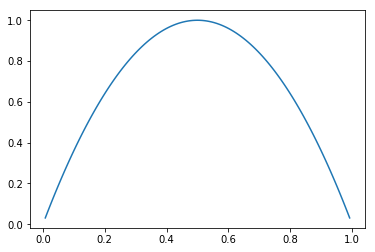

In [38]:
poisson.plot_correct_solution()

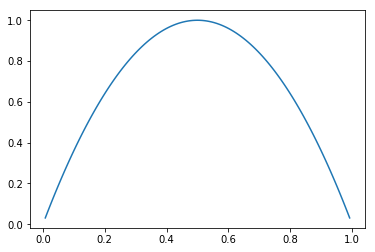

In [39]:
poisson.plot_fmg_solution()

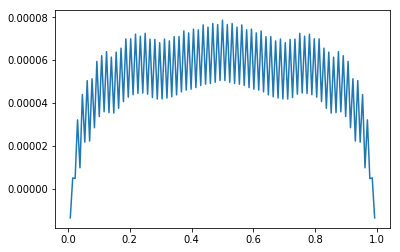

In [40]:
poisson.plot_fmg_solution_error()

# Timing

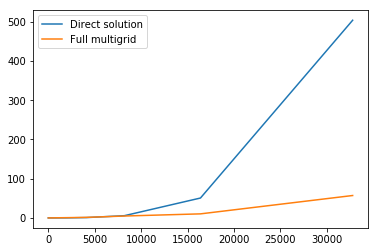

In [21]:
import time

ms = np.array(range(1,10))
ns = 2**ms + 1
times_naive = []
times_mg = []

# Iterate over problem sizes
for i in ms:
    # Time naive solution
    A, b, _ = P_fem(i, f)
    start = time.time()
    np.linalg.solve(A, b)
    end = time.time()
    times_naive.append(end - start)

    # Time full multigrid solution
    start = time.time()
    poisson.solve_fmg(i)
    end = time.time()
    times_mg.append(end - start)

plt.figure()
plt.plot(ns, times_naive, label="Direct solution")
plt.plot(ns, times_mg, label="Full multigrid")
plt.legend()
plt.show()